In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

In [3]:
from pathlib import Path
from ase.tools.utils import export_legend

# ASE: Sepsis Management

This notebook renders results for the experiments on sepsis management environment. The results are expected to be in `results/sepsis` directory. To reproduce the results it suffices to run:

```txt
python -m ase.scripts.sepsis_experiment 8854 \
    --artifacts-dir results/sepsis \
    --mdp-path results/sepsis/mdp_original.pkl \
    --cl-policy-path results/sepsis/cl_policy.pkl \
    --ai-policy-path results/sepsis/ai_policy.pkl \
    --tcfe-threshold 0.8 \
    --num-trajectories 100 \
    --num-cf-samples 100 \
    --max-horizon 40 \
    --shuffle-total-order 5 \
    --trust-values 0.0,0.2,0.4,0.6,0.8,1.0 \
    --posterior-sample-complexity 500
```

For generating the MDP transition matrix, see the `learn_sepsis_mdp.ipynb` notebook. Likewise, for learning AI and clinician policies, see the `learn_sepsis_actors.ipynb` notebook.

In [4]:
_ = sns.set_theme(
    style="white", context="paper",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

In [5]:
seed = 8854
results_dir = Path("./results/sepsis")
plots_dir = Path("./results/plots/sepsis")

## Render Configuration

In this section we define properties of generated plots.

In [6]:
plt_skip_legend = True

plt_palette_agents = {"AI": "#ffa62f", "Clinician": "#c34c17"}
plt_palette_quantities = {"cf-ASE": "#009a5b", "cf-PSE": "#de281b", "TCFE": "#0086be"}

plt_ase_ranges_title = None
plt_ase_ranges_legend_title = None
plt_ase_ranges_x_label = "cf-ASE Value Ranges"
plt_ase_ranges_y_label = "% of Alternative Actions"

plt_ase_trends_title_ai_effect = None
plt_ase_trends_title_cl_effect = None
plt_ase_trends_legend_title = None
plt_ase_trends_x_label = "Trust Parameter $\mu$"
plt_ase_trends_y_label = "Avg. Effect Values"

plt_order_title_ai_effect = None
plt_order_title_cl_effect = None
plt_order_legend_title = None
plt_order_x_label = "Trust Parameter $\mu$"
plt_order_y_label = "Avg. Effect Values"

plt_complexity_title = None
plt_complexity_legend_title = None
plt_complexity_x_label = "Number of CF samples"
plt_complexity_y_label = "Frac. of converged interventions"

## Trajectories

We perform our analysis by sampling $500$ ($100$ per trust parameter $\mu$) trajectories and exhaustively enumerate all counterfactuals. We then select those with total counterfactual effect (TCFE) $\ge 0.8$.

In [42]:
with open(results_dir / str(seed) / "trajectories.pkl", "rb") as f: trajectories = pickle.load(f)

In [43]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals.csv")
df

,traj_id,agent_id,time_step,alternative,trust_level,tcfe
0,0,0,0,0,0.0,0.0
1,0,0,0,1,0.0,0.0
2,0,0,0,2,0.0,0.0
3,0,0,0,3,0.0,0.0
4,0,0,0,4,0.0,0.0
...,...,...,...,...,...,...
53509,599,0,2,2,1.0,1.0
53510,599,0,2,3,1.0,0.0
53511,599,0,2,5,1.0,1.0
53512,599,0,2,6,1.0,1.0


## Calculating Causal Quantities

For selected counterfactual, we proceed to calculate the causal quantities of our interest, namely ASE and PSE.

In [7]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_quantities.csv")
df

,traj_id,agent_id,time_step,alternative,trust_level,tcfe,ase,pse
0,0,1,17,2,0.0,0.94,0.0,0.10
1,0,1,17,4,0.0,0.81,0.0,0.55
2,0,1,17,5,0.0,0.80,0.0,0.67
3,0,1,17,7,0.0,0.84,0.0,0.74
4,0,1,19,6,0.0,1.00,0.0,0.00
...,...,...,...,...,...,...,...,...
9192,599,0,2,0,1.0,1.00,0.0,1.00
9193,599,0,2,2,1.0,1.00,0.0,1.00
9194,599,0,2,5,1.0,1.00,0.0,1.00
9195,599,0,2,6,1.0,1.00,0.0,1.00


## Exploratory Analysis of Selected Counterfactuals

To better understand the distribution of selected counterfactuals with target TCFE value, we perform some rudimentary analysis.

In [8]:
df_curr = df.copy()
df_curr.ase = pd.cut(df_curr.ase, bins=[0.0, 0.25, 0.5, 0.75, 1.0], labels=["[.0, .25]", "(.25, .5]", "(.5, .75]", "(.75, 1.0]"], include_lowest=True)
df_curr["effect_agent"] = 1 - df_curr.agent_id
df_curr["effect_agent"] = pd.Categorical(df_curr["effect_agent"]).rename_categories({0: "AI", 1: "Clinician"})

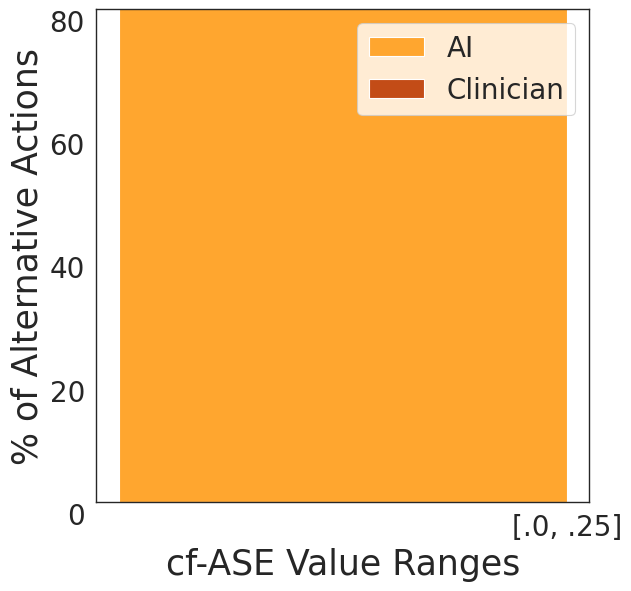

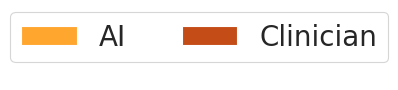

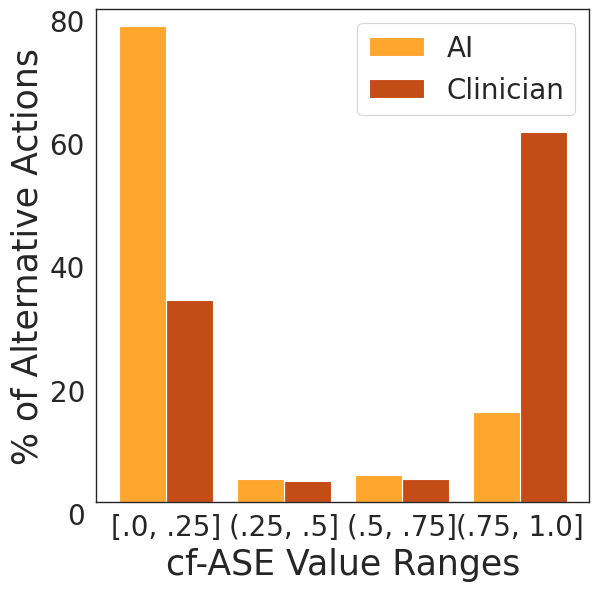

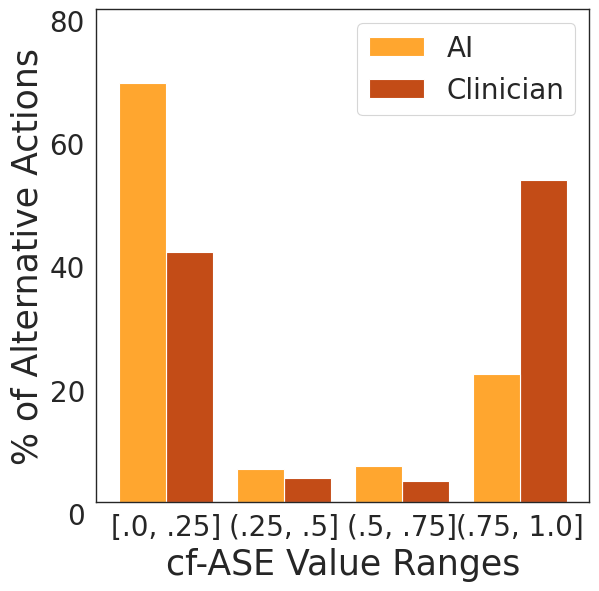

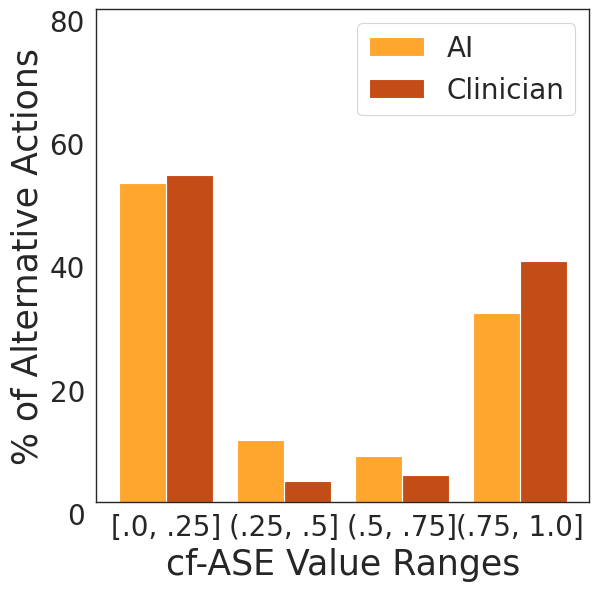

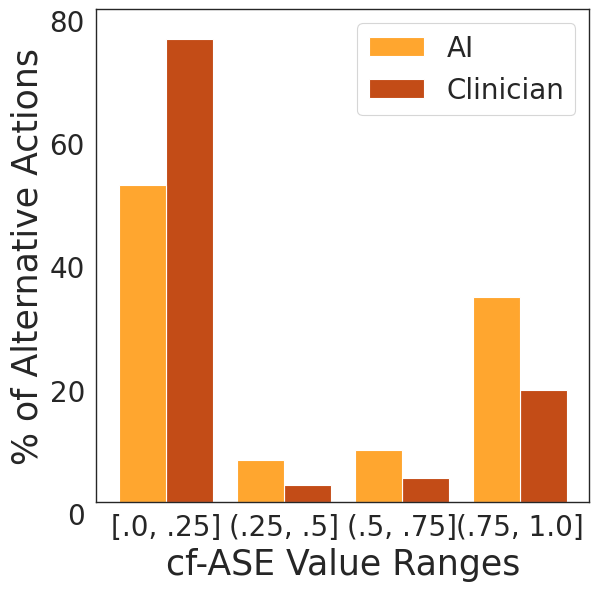

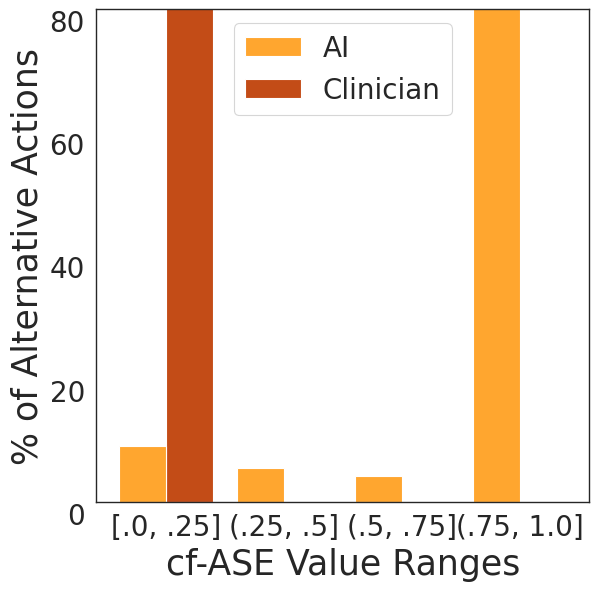

In [9]:
for i, trust_level in enumerate(df_curr.trust_level.unique()):
    fig, ax = plt.subplots(1)

    ax = sns.histplot(data=df_curr[df_curr.trust_level == trust_level], x="ase", hue="effect_agent", stat="percent", palette=plt_palette_agents, multiple="dodge", shrink=0.8, ax=ax, alpha=1.0, discrete=True, cumulative=False, common_norm=False, legend=True)
    _ = ax.set_title(plt_ase_ranges_title.format(trust_level=trust_level) if plt_ase_ranges_title else None)
    _ = ax.set_xlabel(plt_ase_ranges_x_label)
    _ = ax.set_ylabel(plt_ase_ranges_y_label)
    _ = ax.get_legend().set_title(plt_ase_ranges_legend_title)
    _ = ax.set_ylim(0, 80)
    _ = ax.set_yticks([0, 20, 40, 60, 80])
    _ = [a.set_va("top") for a in ax.get_yticklabels()]
    _ = ax.set_box_aspect(1)

    # separately exports legend, only once
    if i == 0:
        legend_fig, legend = export_legend(fig, ax)
        legend_fig.savefig(plots_dir / "appendix" / "legends" / "ranges_legend.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

    # removes legend from main plot
    # if plt_skip_legend: _ = ax.get_legend().remove()
    fig.savefig(plots_dir / "appendix" / "ase_ranges" / f"ranges_tl{trust_level}.pdf", bbox_inches="tight")

## Trends of ASE

To demonstrate the necessity and overall intuitiveness of agent-specific effects, we split our analysis based on the acting agent (AI or clinician). To this end, we show the *AI-Specific Effect*, which quantifies the effect intervening on clinician's action has on the outcome, through the future actions of the AI. Likewise, we show the *CL-Specific Effect*, which is the effect intervening on AI's action has on the outcome, through the future actions of the clinician.

In [47]:
df_ai = df.iloc[np.where((df.agent_id == 0) & (df.trust_level == 0.6))]
len(df_ai[df_ai.ase > 0.75]) / len(df_ai)

0.3911392405063291

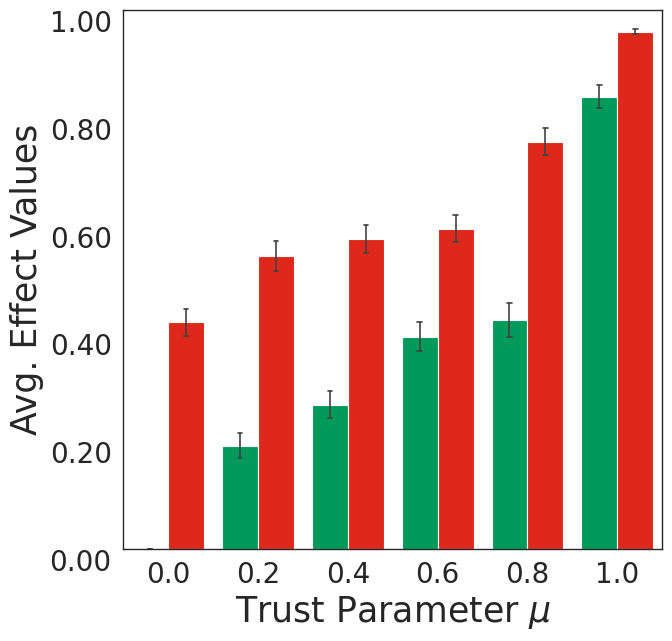

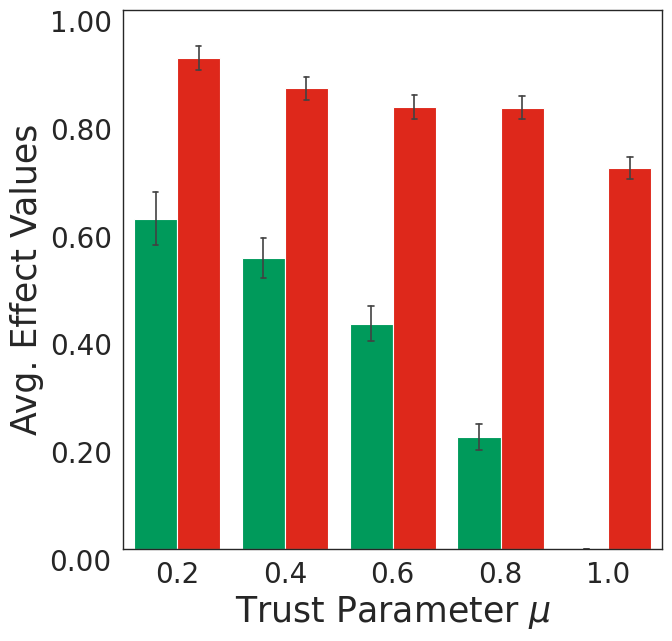

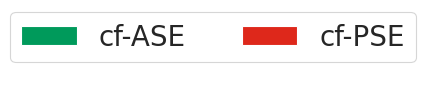

In [48]:
# how changing actions of human affects the outcome through actions of AI
df_human = df[df.agent_id == 1]
df_human = df_human.drop(columns=["tcfe"])
df_human = df_human.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level"])
df_human.variable = pd.Categorical(df_human.variable).rename_categories({"ase": "cf-ASE", "pse": "cf-PSE"})

# how changing actions of AI affects the outcome through actions of human
df_ai = df[df.agent_id == 0]
df_ai = df_ai.drop(columns=["tcfe"])
df_ai = df_ai.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level"])
df_ai.variable = pd.Categorical(df_ai.variable).rename_categories({"ase": "cf-ASE", "pse": "cf-PSE"})

# plots the AI-Specific effect
fig_ai, ax_ai = plt.subplots(1, 1, figsize=(7, 7))
_ = sns.barplot(data=df_human, x="trust_level", y="value", hue="variable", palette=plt_palette_quantities, errorbar=("se", 2), errwidth=1.2, capsize=0.05, saturation=1.0, ax=ax_ai) 
_ = ax_ai.set_title(plt_ase_trends_title_ai_effect)
_ = ax_ai.set_xlabel(plt_ase_trends_x_label)
_ = ax_ai.set_ylabel(plt_ase_trends_y_label)
_ = ax_ai.set_ylim(0.0, 1.0)
_ = ax_ai.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
_ = ax_ai.set_box_aspect(1)
_ = [a.set_va("top") for a in ax_ai.get_yticklabels()]
_ = ax_ai.get_legend().set_title(plt_ase_trends_legend_title)

# plots the CL-Specific effect
fig_cl, ax_cl = plt.subplots(1, 1, figsize=(7, 7))
_ = sns.barplot(data=df_ai, x="trust_level", y="value", hue="variable", palette=plt_palette_quantities, errorbar=("se", 2), errwidth=1.2, capsize=0.05, saturation=1.0, ax=ax_cl) 
_ = ax_cl.set_title(plt_ase_trends_title_cl_effect)
_ = ax_cl.set_xlabel(plt_ase_trends_x_label)
_ = ax_cl.set_ylabel(plt_ase_trends_y_label)
_ = ax_cl.set_box_aspect(1)
_ = ax_cl.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
_ = ax_cl.set_ylim(0.0, 1.0)
_ = [a.set_va("top") for a in ax_cl.get_yticklabels()]
_ = ax_cl.get_legend().set_title(plt_ase_trends_legend_title)

# separately exports legend
legend_fig, legend = export_legend(fig_cl, ax_cl)
legend_fig.savefig(plots_dir / "legends" / "ai_cl_specific_effect.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# exports plots
if plt_skip_legend: _ = ax_ai.get_legend().remove()
fig_ai.savefig(plots_dir / "ase" / f"ai_specific_effect.pdf", bbox_inches="tight")

if plt_skip_legend: _ = ax_cl.get_legend().remove()
fig_cl.savefig(plots_dir / "ase" / f"cl_specific_effect.pdf", bbox_inches="tight")

## Order Robustness

To demonstrate that calculation of ASE is robust to the assumption of the total order and recovers the expected trends regardless, we repeat the above's calculations across $5$ randomly sampled total orders for both environment and action variables.

In [65]:
df_wrong_order = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_order_error.csv")
df_wrong_order

,traj_id,agent_id,time_step,alternative,order,trust_level,tcfe,ase,pse,ase_w_error,pse_w_error
0,0,1,17,2,order_0,0.0,0.94,0.0,0.10,0.0,0.03
1,0,1,17,4,order_0,0.0,0.81,0.0,0.55,0.0,0.06
2,0,1,17,5,order_0,0.0,0.80,0.0,0.67,0.0,0.11
3,0,1,17,7,order_0,0.0,0.84,0.0,0.74,0.0,0.04
4,0,1,19,6,order_0,0.0,1.00,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
45980,599,0,2,0,order_4,1.0,1.00,0.0,1.00,0.0,1.00
45981,599,0,2,2,order_4,1.0,1.00,0.0,1.00,0.0,1.00
45982,599,0,2,5,order_4,1.0,1.00,0.0,1.00,0.0,1.00
45983,599,0,2,6,order_4,1.0,1.00,0.0,1.00,0.0,1.00


In [66]:
df_curr = df_wrong_order.drop(["tcfe", "ase", "pse"], axis=1)
df_curr = df_curr.rename(columns={"ase_w_error": "cf-ASE", "pse_w_error": "cf-PSE"})

# how changing actions of human affects the outcome through actions of AI
df_human = df_curr[df_curr.agent_id == 1]
df_human = df_human.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level", "order"])

# how changing actions of AI affects the outcome through actions of human
df_ai = df_curr[df_curr.agent_id == 0]
df_ai = df_ai.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level", "order"])

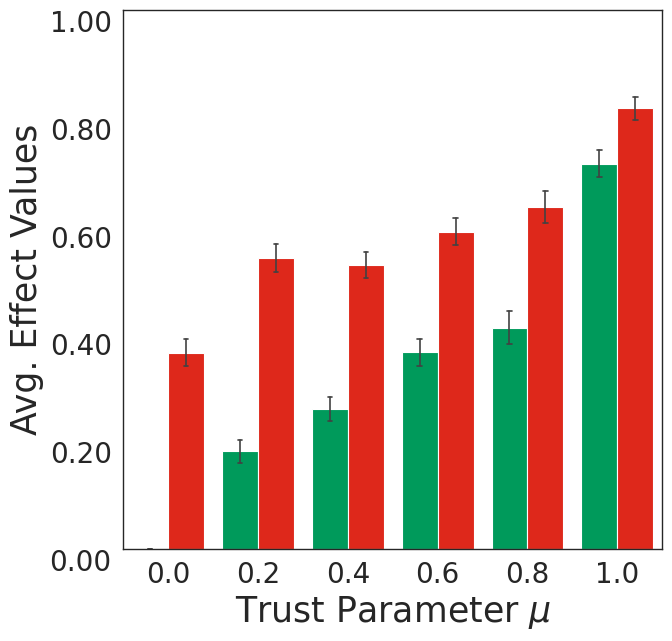

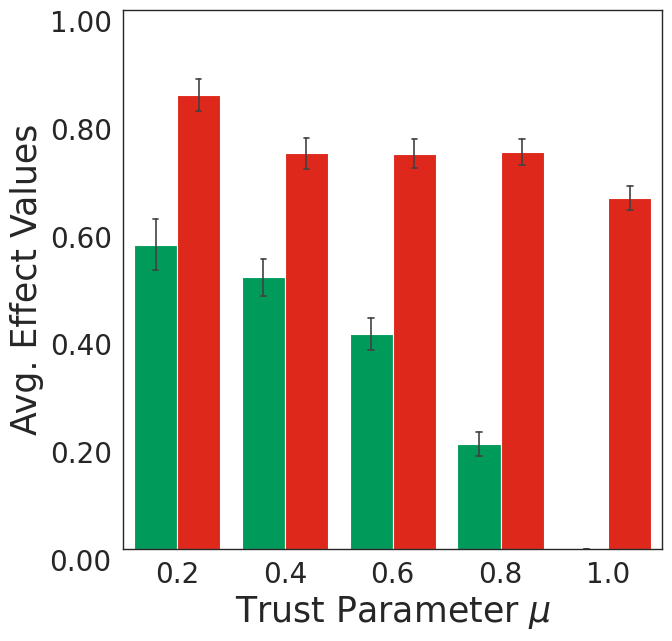

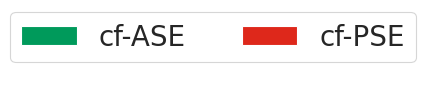

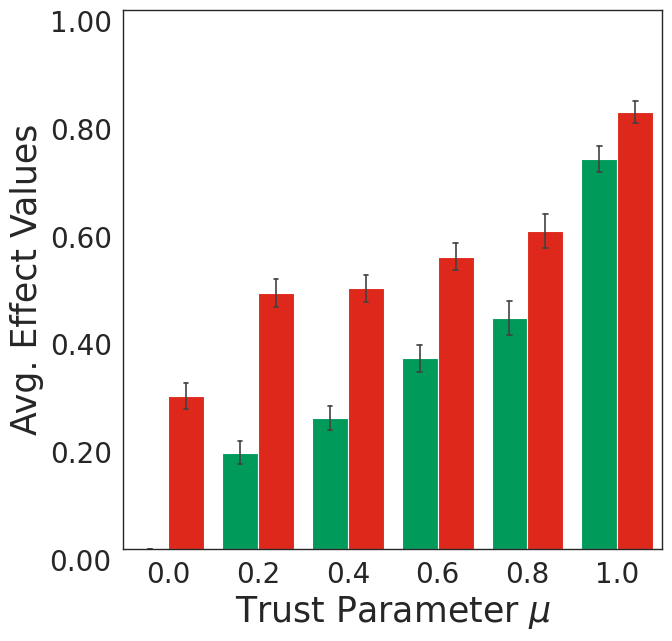

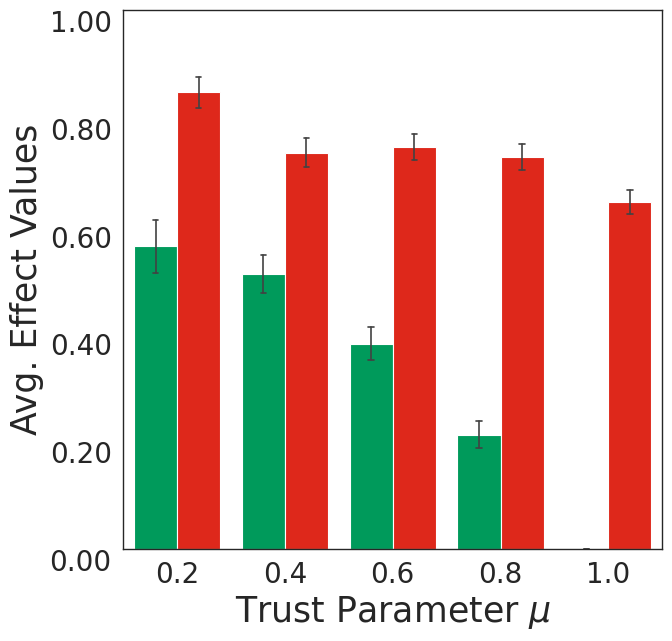

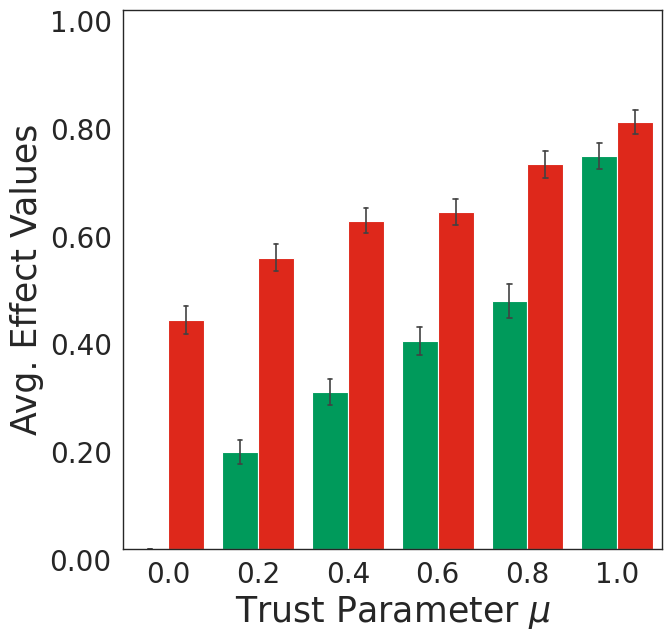

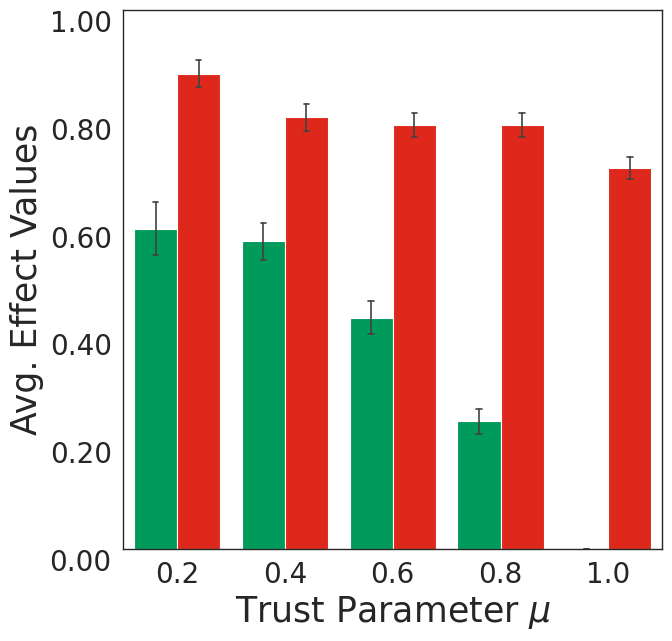

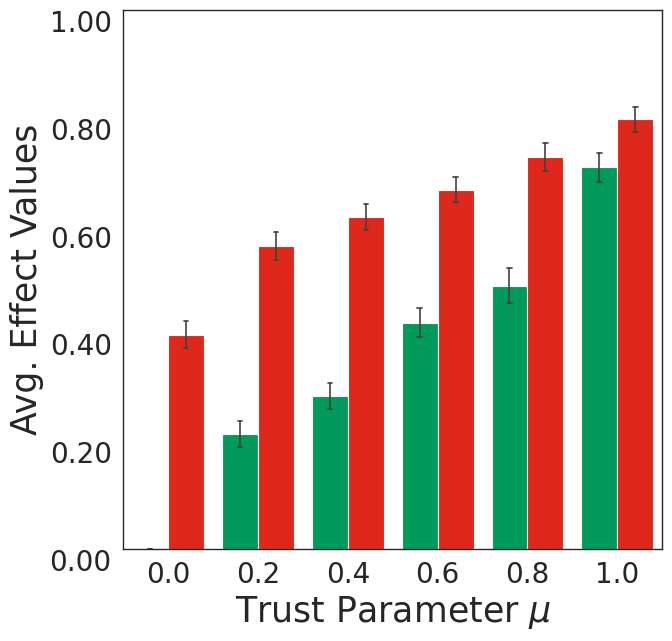

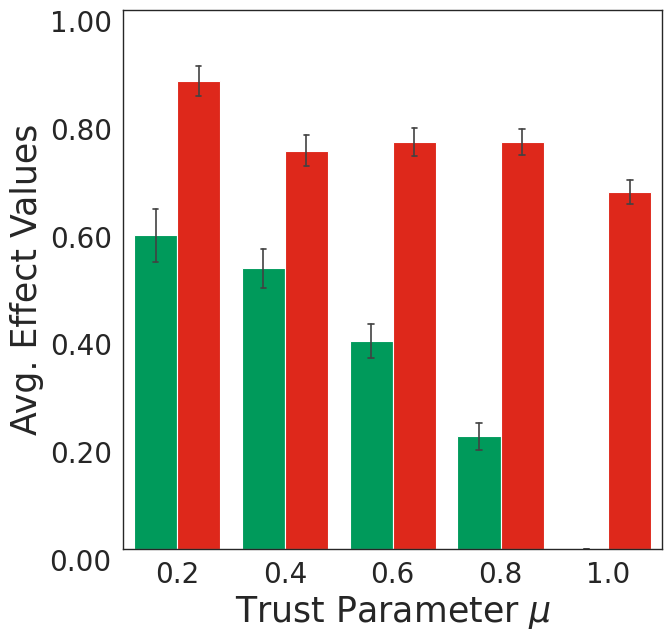

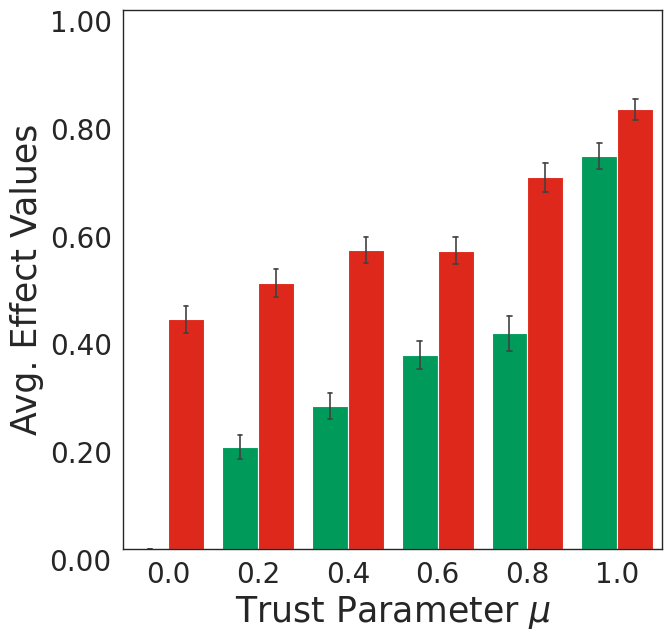

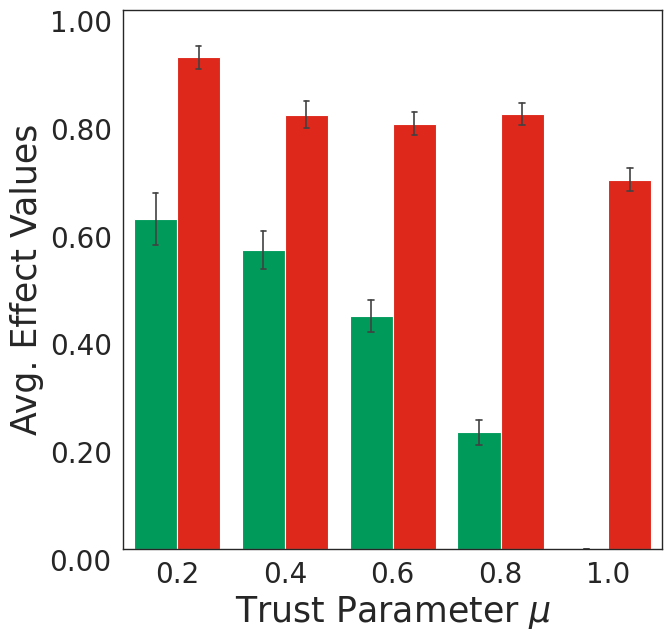

In [69]:
for i, order in enumerate(df_curr.order.unique()):
    fig_ai, ax_ai = plt.subplots(1, 1, figsize=(7, 7))
    sns.barplot(data=df_human[df_human.order == order], x="trust_level", y="value", hue="variable", palette=plt_palette_quantities, errorbar=("se", 2), errwidth=1.2, capsize=0.05, saturation=1.0, ax=ax_ai) 
    _ = ax_ai.set_title(plt_order_title_ai_effect.format(order=i) if plt_order_title_ai_effect else None)
    _ = ax_ai.set_xlabel(plt_order_x_label)
    _ = ax_ai.set_ylabel(plt_order_y_label)
    _ = ax_ai.set_ylim(0, 1.0)
    _ = [a.set_va("top") for a in ax_ai.get_yticklabels()]
    _ = ax_ai.set_box_aspect(1)
    _ = ax_ai.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    _ = ax_ai.get_legend().set_title(plt_order_legend_title)

    fig_cl, ax_cl = plt.subplots(1, 1, figsize=(7, 7))
    sns.barplot(data=df_ai[df_ai.order == order], x="trust_level", y="value", hue="variable", palette=plt_palette_quantities, errorbar=("se", 2), errwidth=1.2, capsize=0.05, saturation=1.0, ax=ax_cl) 
    _ = ax_cl.set_title(plt_order_title_cl_effect.format(order=i) if plt_order_title_cl_effect else None)
    _ = ax_cl.set_xlabel(plt_order_x_label)
    _ = ax_cl.set_ylabel(plt_order_y_label)
    _ = ax_cl.set_ylim(0, 1.0)
    _ = ax_cl.set_box_aspect(1)
    _ = ax_cl.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    _ = [a.set_va("top") for a in ax_cl.get_yticklabels()]
    _ = ax_cl.get_legend().set_title(plt_order_legend_title)

    if i == 0:
        # separately exports legend only once
        legend_fig, legend = export_legend(fig_cl, ax_cl)
        legend_fig.savefig(plots_dir / "appendix" / "legends" / f"order_robustness.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

    # exports plots without legend
    if plt_skip_legend: _ = ax_ai.get_legend().remove()
    fig_ai.savefig(plots_dir / "appendix" / "order_robustness" / f"{order}_ai_specific_effect.pdf", bbox_inches="tight")

    if plt_skip_legend: _ = ax_cl.get_legend().remove()
    fig_cl.savefig(plots_dir / "appendix" / "order_robustness" / f"{order}_cl_specific_effect.pdf", bbox_inches="tight")

## Sample Complexity

In this section, we empirically showcase convergence of ASE, PSE and TCFE, for different number of posterior samples. In our analysis, we consider the following candidates $[10, 20, ..., 100]$. For each candidate, we calculate (total) ASE, PSE as well as TCFE for a randomly selected subset of 500 interventions, across $10$ random seeds. Then, for each candidate, we plot percentage of interventions whose variance across seeds is smaller or equal to $\epsilon=0.01$.

In [52]:
df_complexity = pd.read_csv(results_dir / str(seed) / "sample_complexity_analysis.csv")
df_complexity

,intr_id,seed,num_cf_samples,ase,pse,tcfe
0,0,18879,10,0.00,0.00,0.00
1,1,18879,10,0.00,1.00,1.00
2,2,18879,10,0.00,0.00,0.00
3,3,18879,10,0.00,0.00,0.00
4,4,18879,10,0.00,0.20,0.10
...,...,...,...,...,...,...
49995,495,4416,100,0.15,0.12,0.19
49996,496,4416,100,0.00,0.00,0.00
49997,497,4416,100,0.00,0.00,0.00
49998,498,4416,100,0.04,0.11,0.26


In [53]:
eps = 0.01

In [54]:
df_curr = df_complexity.groupby(["intr_id", "num_cf_samples"]).var().reset_index()
df_curr.pse = (df_curr.pse <= eps).astype(int)
df_curr.ase = (df_curr.ase <= eps).astype(int)
df_curr.tcfe = (df_curr.tcfe <= eps).astype(int)

In [55]:
df_curr

,intr_id,num_cf_samples,seed,ase,pse,tcfe
0,0,10,1.128085e+09,1,1,1
1,0,20,1.128085e+09,1,1,1
2,0,30,1.128085e+09,1,1,1
3,0,40,1.128085e+09,1,1,1
4,0,50,1.128085e+09,1,1,1
...,...,...,...,...,...,...
4995,499,60,1.128085e+09,1,1,1
4996,499,70,1.128085e+09,1,1,1
4997,499,80,1.128085e+09,1,1,1
4998,499,90,1.128085e+09,1,1,1


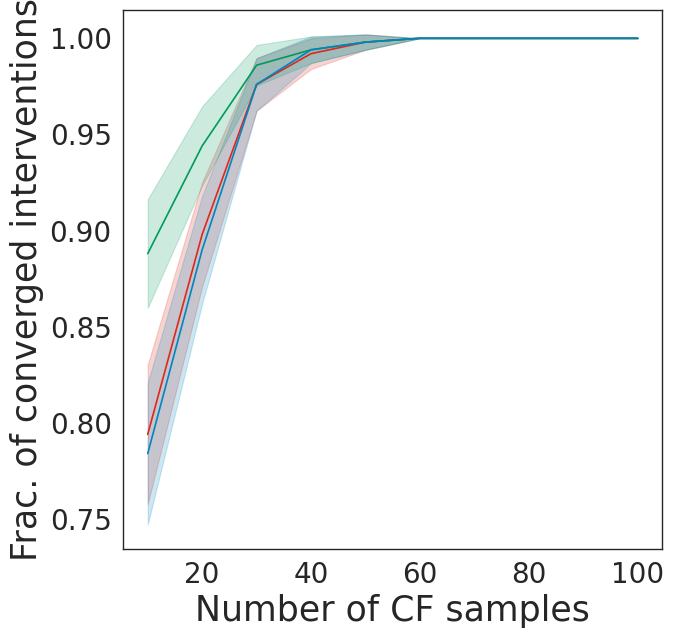

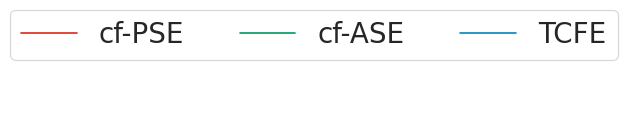

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# plots the convergence
_ = sns.lineplot(data=df_curr, x="num_cf_samples", y="pse", label="cf-PSE", color=plt_palette_quantities["cf-PSE"], errorbar=("se", 2), ax=ax)
_ = sns.lineplot(data=df_curr, x="num_cf_samples", y="ase", label="cf-ASE", color=plt_palette_quantities["cf-ASE"], errorbar=("se", 2), ax=ax)
_ = sns.lineplot(data=df_curr, x="num_cf_samples", y="tcfe", label="TCFE", color=plt_palette_quantities["TCFE"], errorbar=("se", 2), ax=ax)
_ = ax.set_title(plt_complexity_title)
_ = ax.set_ylabel(plt_complexity_y_label)
_ = ax.set_xlabel(plt_complexity_x_label)
_ = ax.set_box_aspect(1)
_ = ax.get_legend().set_title(plt_complexity_legend_title)

# separately exports legend
legend_fig, legend = export_legend(fig, ax)
legend_fig.savefig(plots_dir / "appendix" / "legends" / "sample_complexity.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# removes legend from main plot
if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "appendix" / "sample_complexity" / "sample_complexity.pdf", bbox_inches="tight")